# Feature Selection with RBM

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import scipy
import sklearn
import skimage #scikit learn's image package
import os # allows for access to operating system

from skimage.io import imread # allows for reading and writing images - Image reading and writing via imread
from skimage import img_as_float # convert images to floats - either -1 to 1 or 0 to 1
from skimage.transform import resize
from sklearn.neural_network import BernoulliRBM
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import clone

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
# check to see what files are available in the bees folder - note: need to use backslashes!!
print(os.listdir('C:/Users/Cmiller/Downloads/bees/'))

['bee_data.csv', 'bee_imgs', '__MACOSX']


In [4]:
# read in bee data (csv) from bees folder 
data = pd.read_csv('C:/Users/Cmiller/Downloads/bees/bee_data.csv')
print(data.head())

          file     date   time        location  zip code subspecies  \
0  041_066.png  8/28/18  16:07  Alvin, TX, USA     77511         -1   
1  041_072.png  8/28/18  16:07  Alvin, TX, USA     77511         -1   
2  041_073.png  8/28/18  16:07  Alvin, TX, USA     77511         -1   
3  041_067.png  8/28/18  16:07  Alvin, TX, USA     77511         -1   
4  041_059.png  8/28/18  16:07  Alvin, TX, USA     77511         -1   

              health  pollen_carrying   caste  
0  hive being robbed            False  worker  
1  hive being robbed            False  worker  
2  hive being robbed            False  worker  
3  hive being robbed            False  worker  
4  hive being robbed            False  worker  


In [5]:
# get the image names from the dataset
img_names = list(data['file'])

# create empty list for storing images with directory
img_paths = []

# tie image names from file to directory string
for img in img_names:
    img_paths.append("C:/Users/Cmiller/Downloads/bees/bee_imgs/"+img)

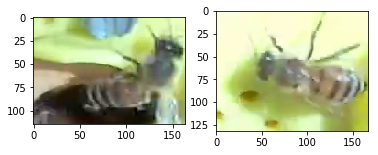

In [6]:
# check to see if all is working by getting some sample images
img0 = imread(img_paths[0])
img2 = imread(img_paths[2])

plt.subplot(121)
plt.imshow(img0)
plt.subplot(122)
plt.imshow(img2)
plt.show()

In [7]:
# resize images so they all are same size
images = []
for im in img_paths:
    images.append(resize(imread(im),(100,100,3)))
         
# grayscale images to reduce to 2-D arrays                         
img_gray = []
for im in images:
    img_gray.append(skimage.color.rgb2gray(im))

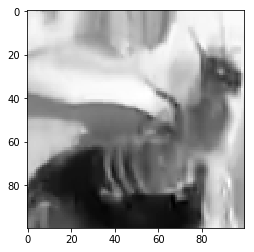

In [8]:
plt.imshow(img_gray[0], cmap='gray')
plt.show()

In [9]:
arr = np.asarray(img_gray)
twoD_arr = arr.reshape(arr.shape[0], -1)
print(twoD_arr.shape)

(5172, 10000)


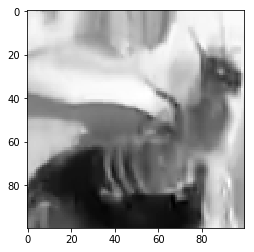

In [9]:
plt.imshow(twoD_arr[0].reshape(100,100), cmap='gray')
plt.show()

In [10]:
rbm = BernoulliRBM(n_components=1000, random_state=0)
rbm.fit(twoD_arr)

BernoulliRBM(batch_size=10, learning_rate=0.1, n_components=1000, n_iter=10,
       random_state=0, verbose=0)

In [11]:
rbm.score_samples(twoD_arr)

array([ -7681.73843195,  -6158.07540331, -10107.19302282, ...,
        -4575.79100918,  -6922.61321526,  -6547.28545632])

In [12]:
rbm.transform(twoD_arr).shape

(5172, 1000)

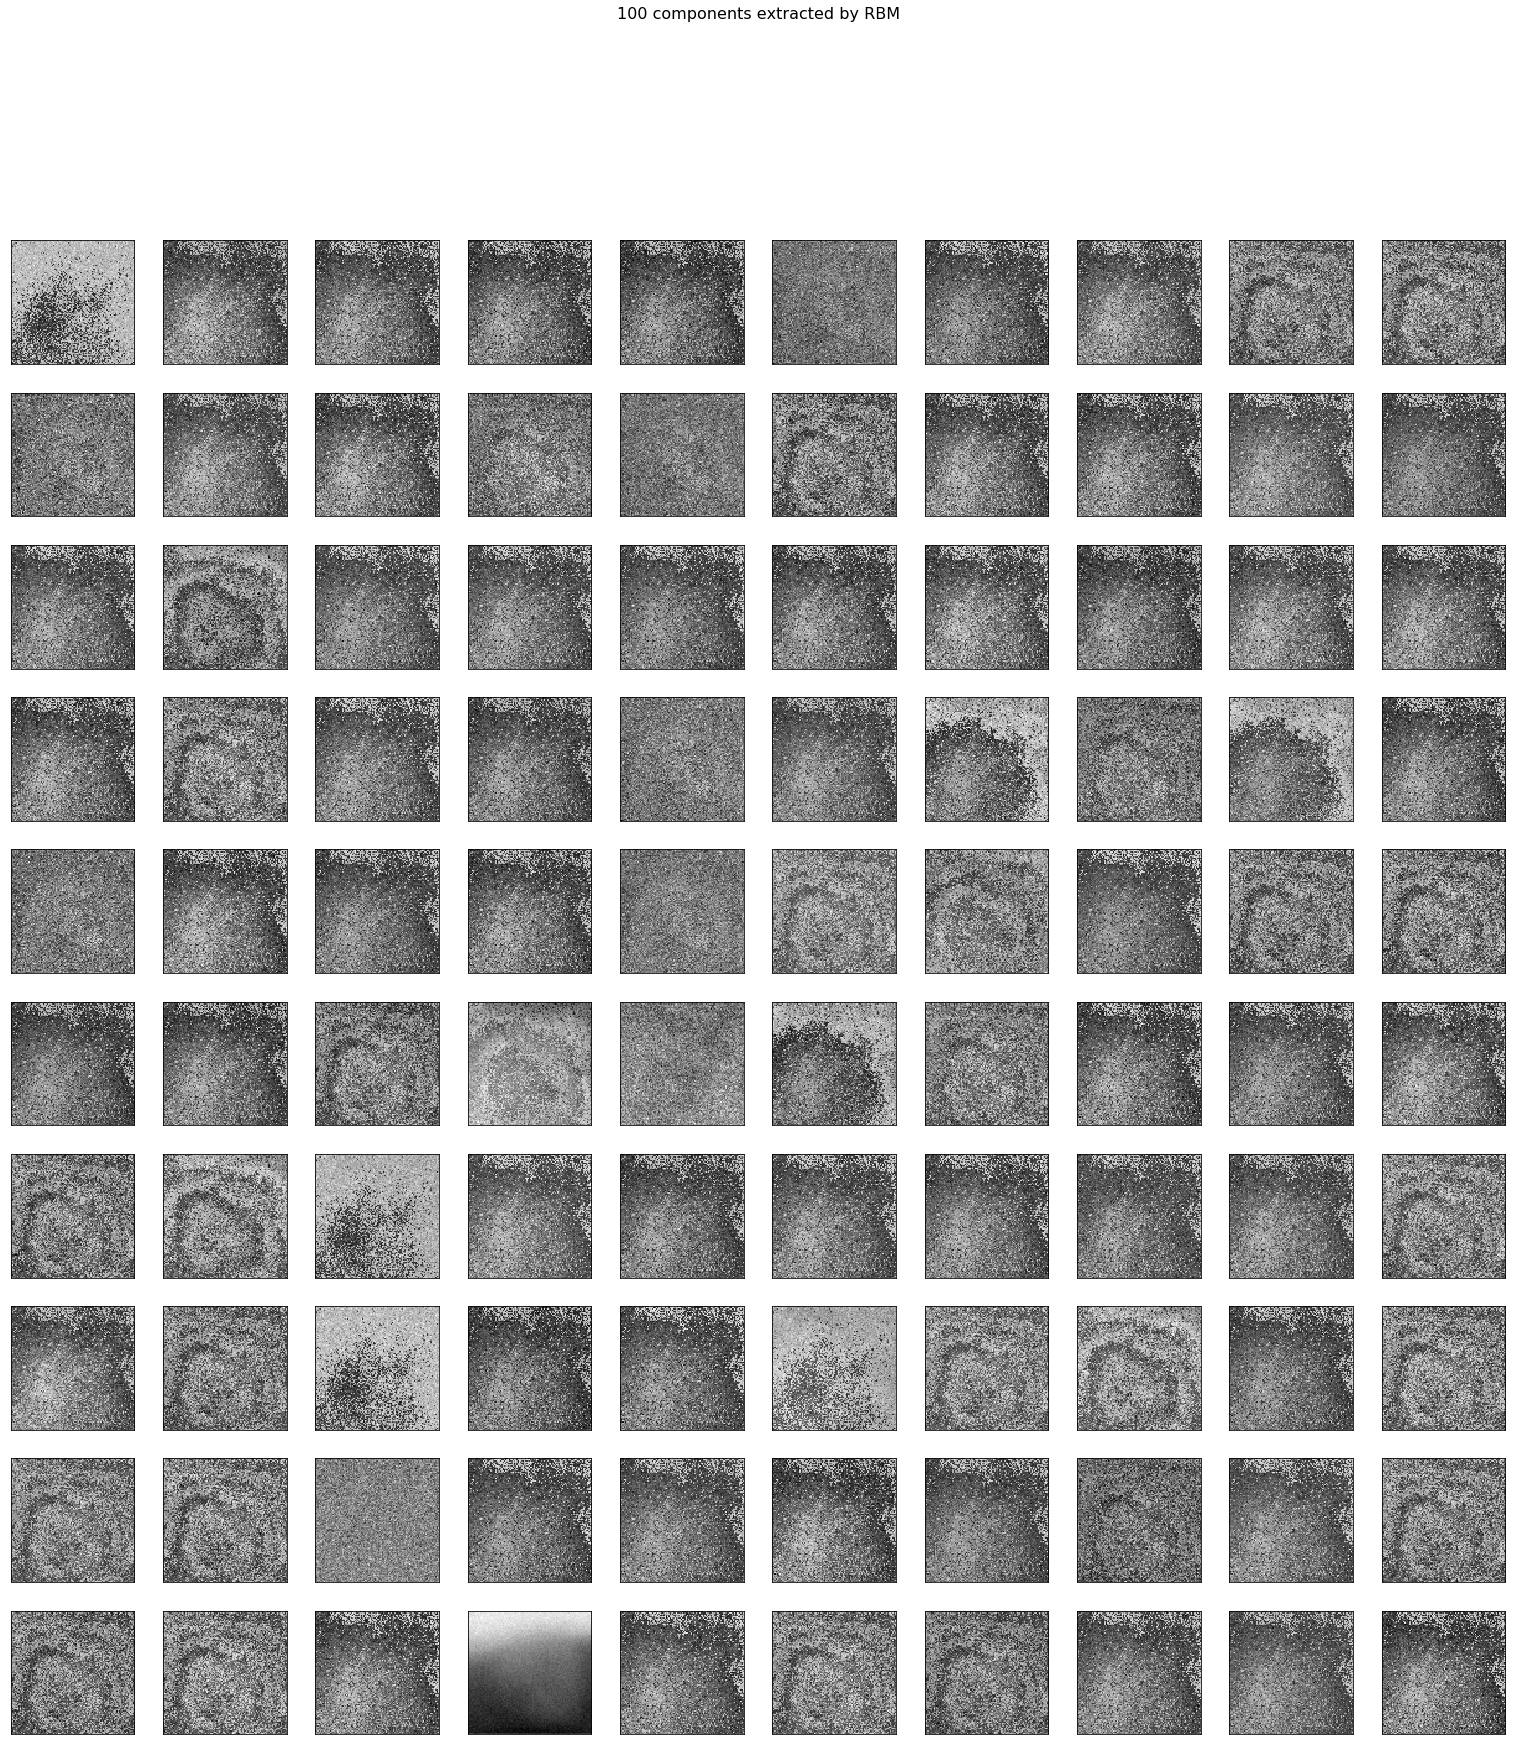

In [13]:
plt.figure(figsize=(25, 25))
for i, comp in enumerate(rbm.components_[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((100,100)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

In [14]:
# add the images to the data
data['gray_images'] = img_gray
data['color_paths'] = img_paths
data['resized_color'] = images

In [15]:
subspecies = data.subspecies.unique()
print(data.subspecies.value_counts())

Italian honey bee        3008
Russian honey bee         527
Carniolan honey bee       501
1 Mixed local stock 2     472
-1                        428
VSH Italian honey bee     199
Western honey bee          37
Name: subspecies, dtype: int64


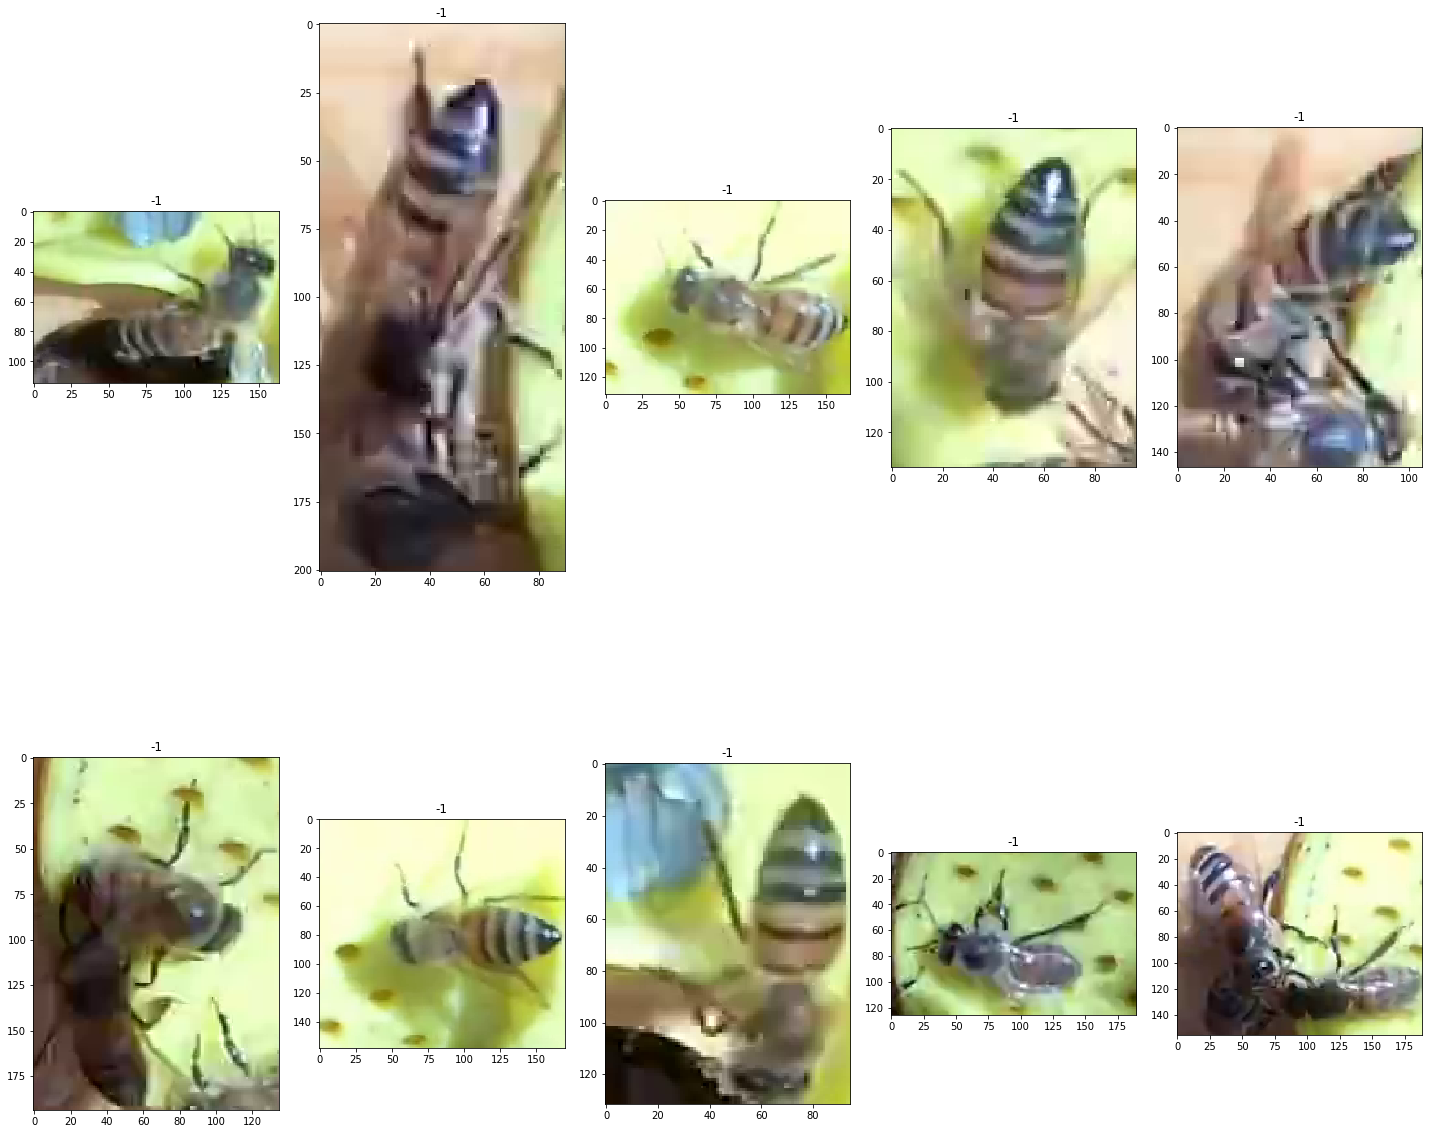

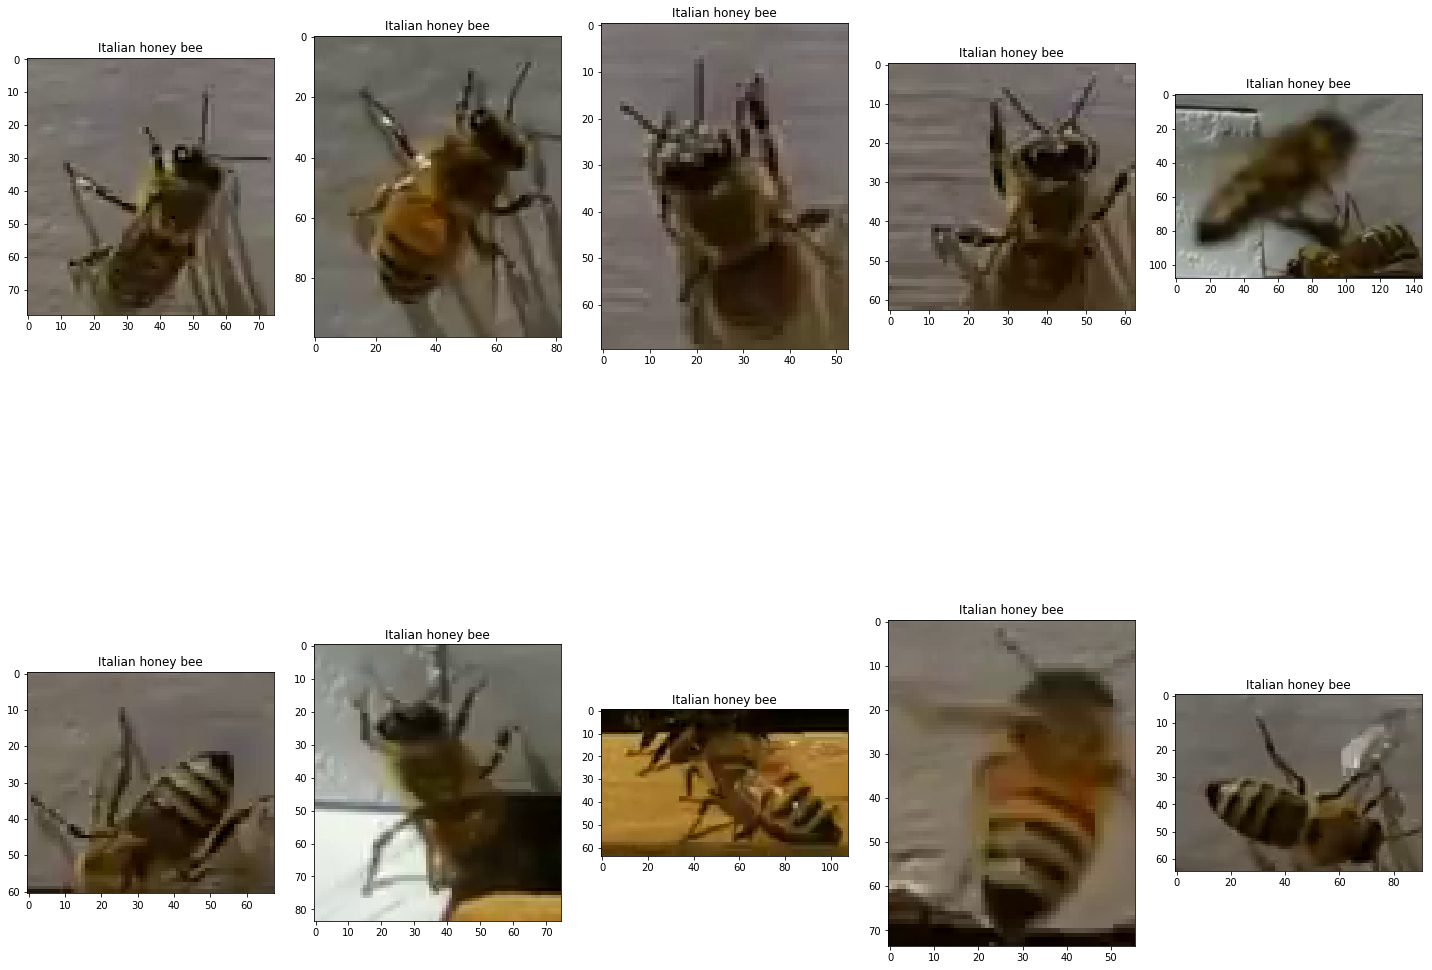

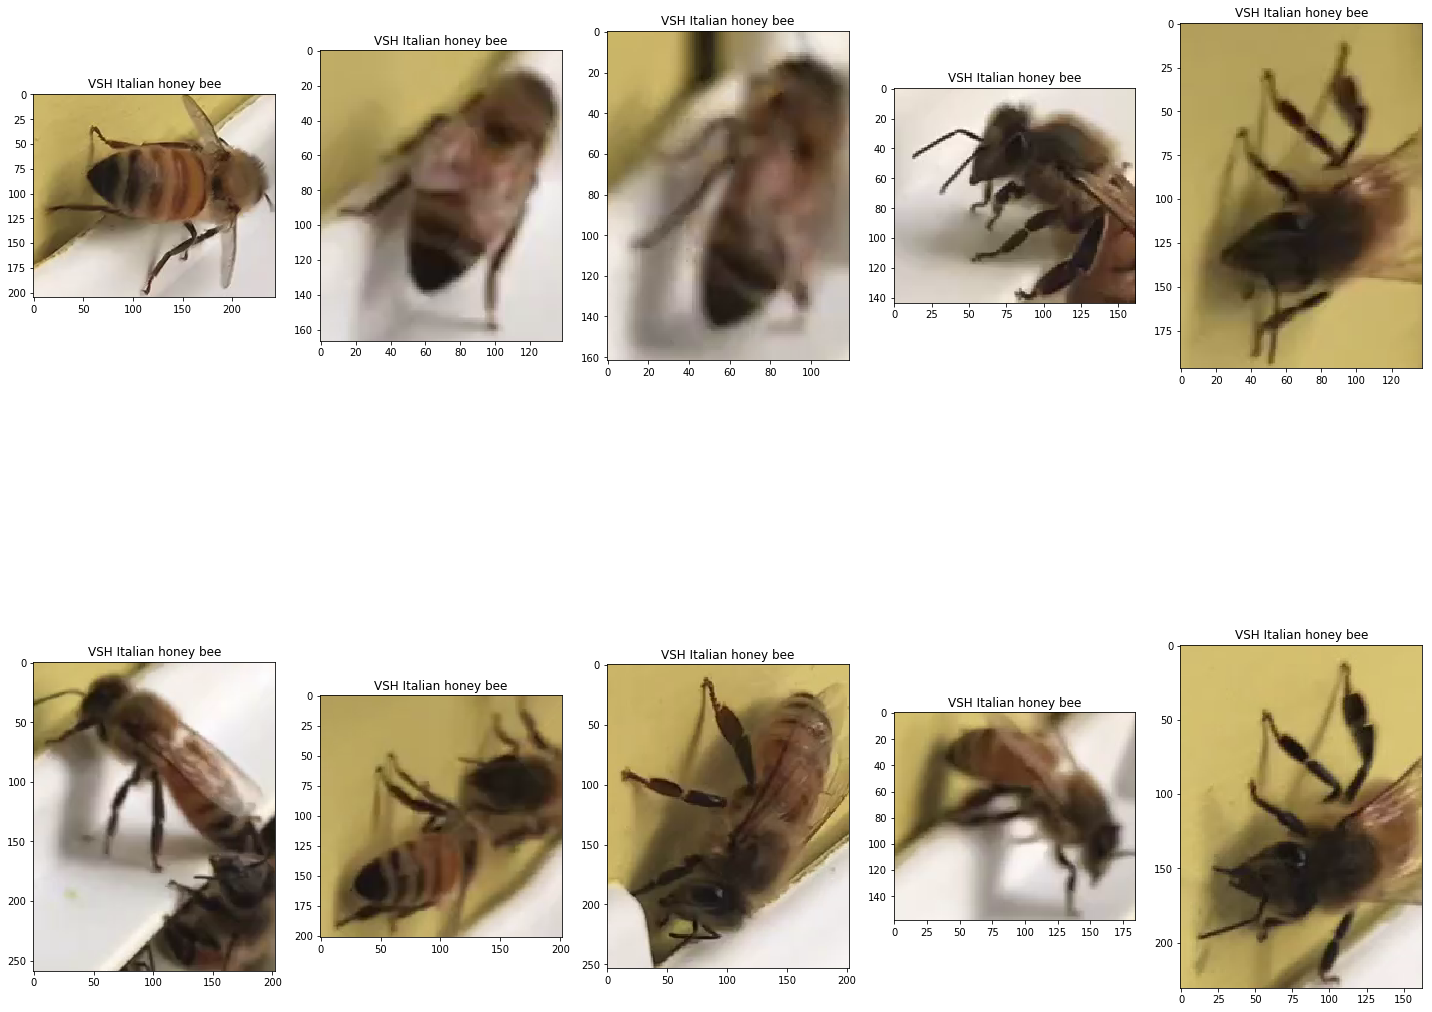

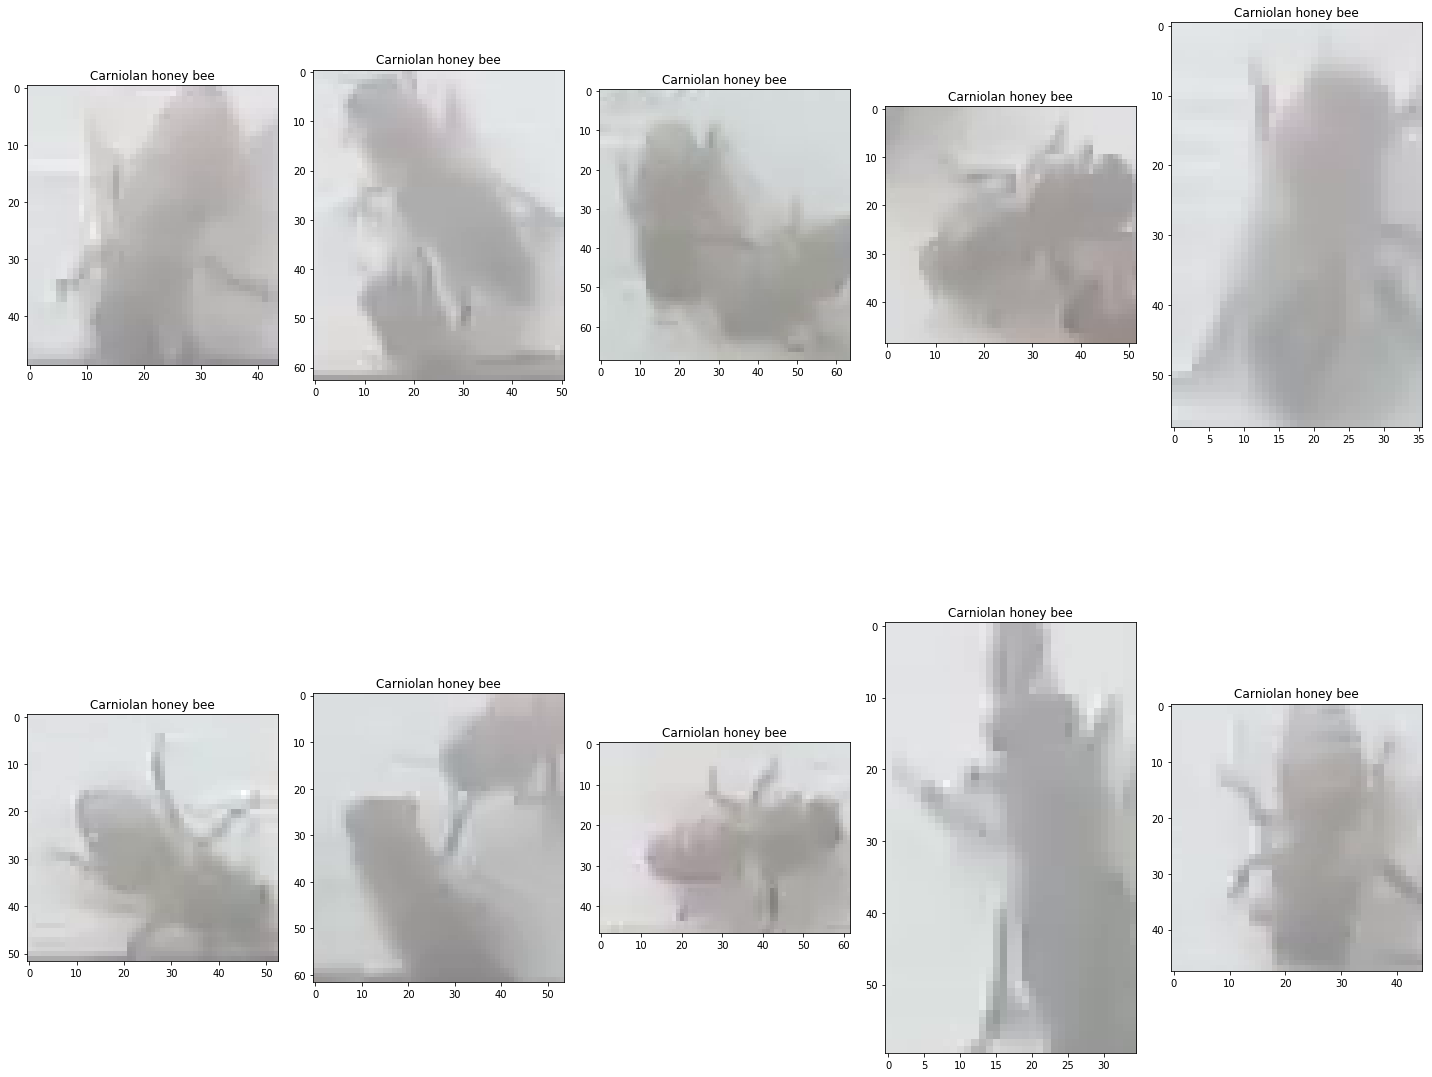

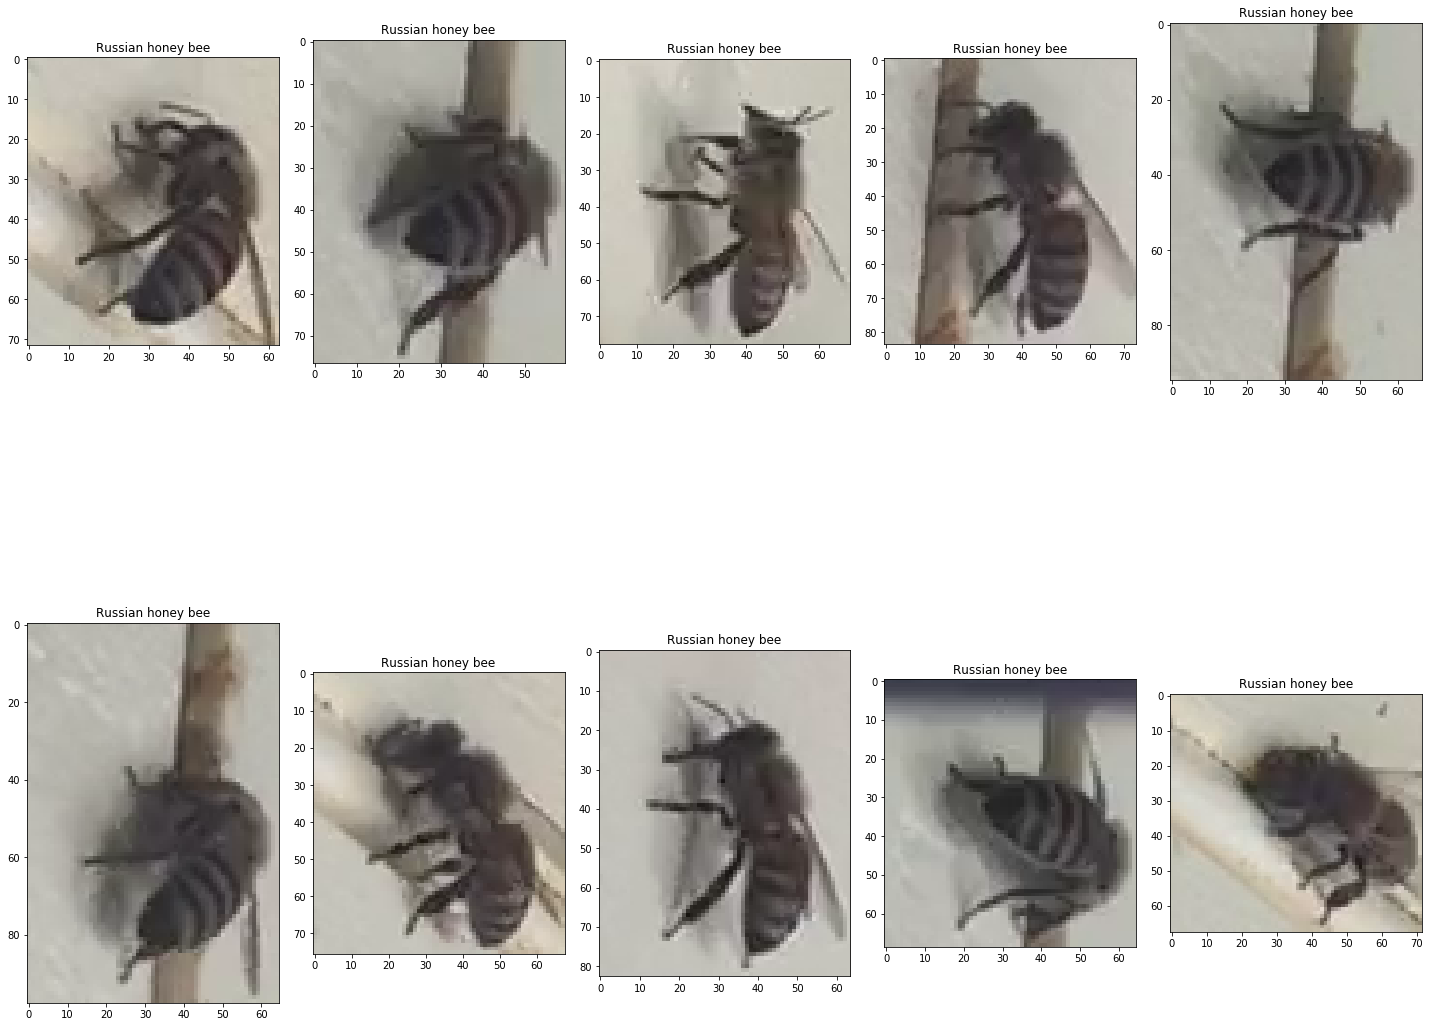

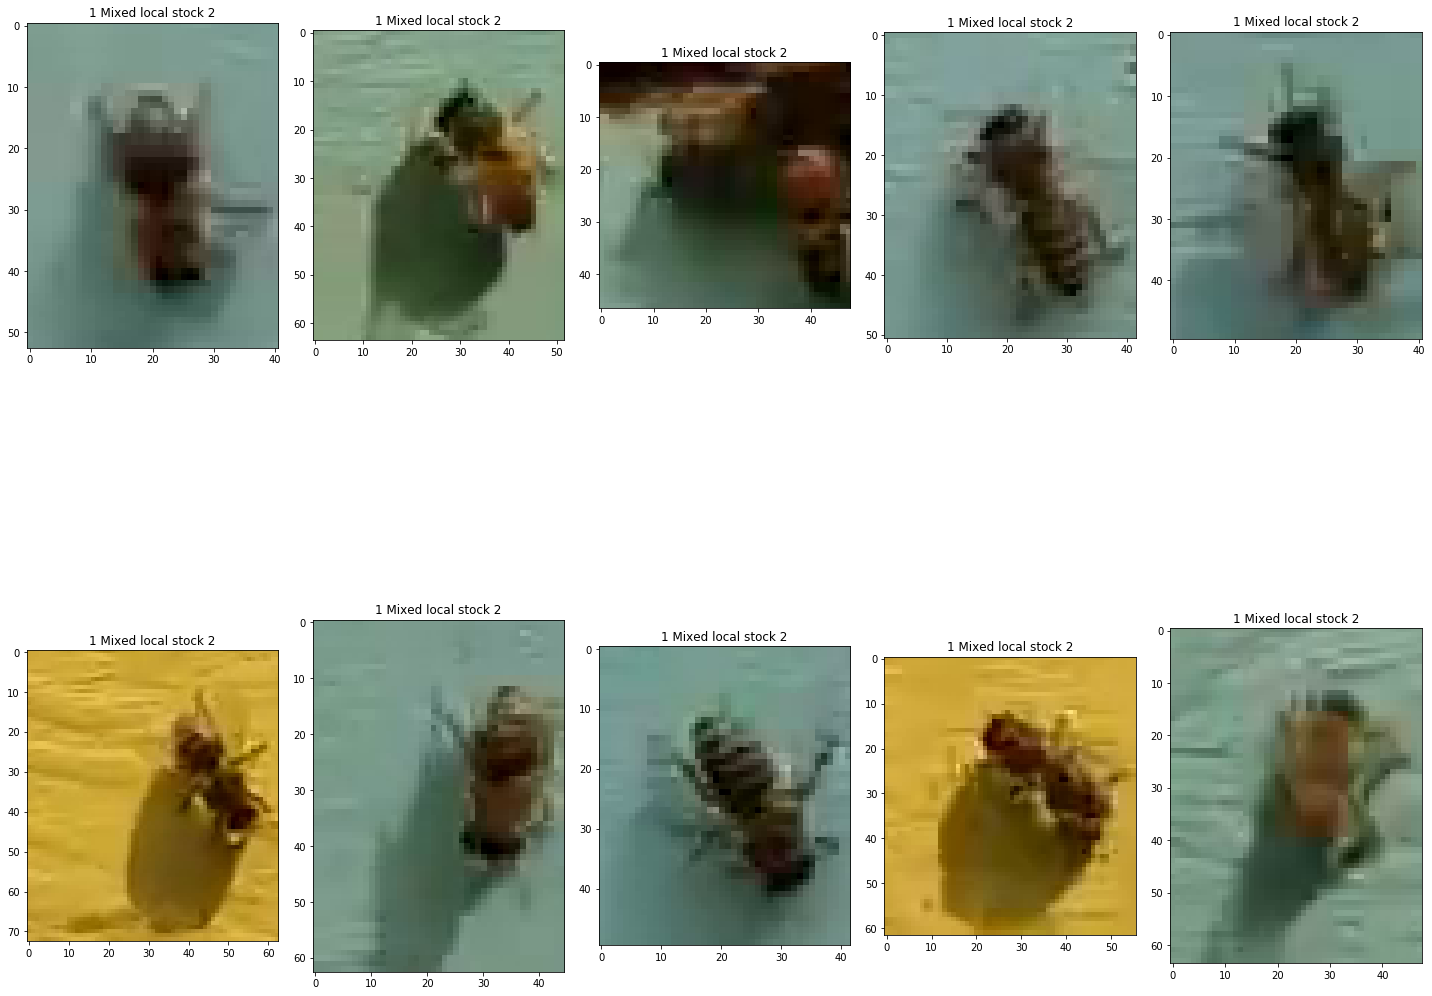

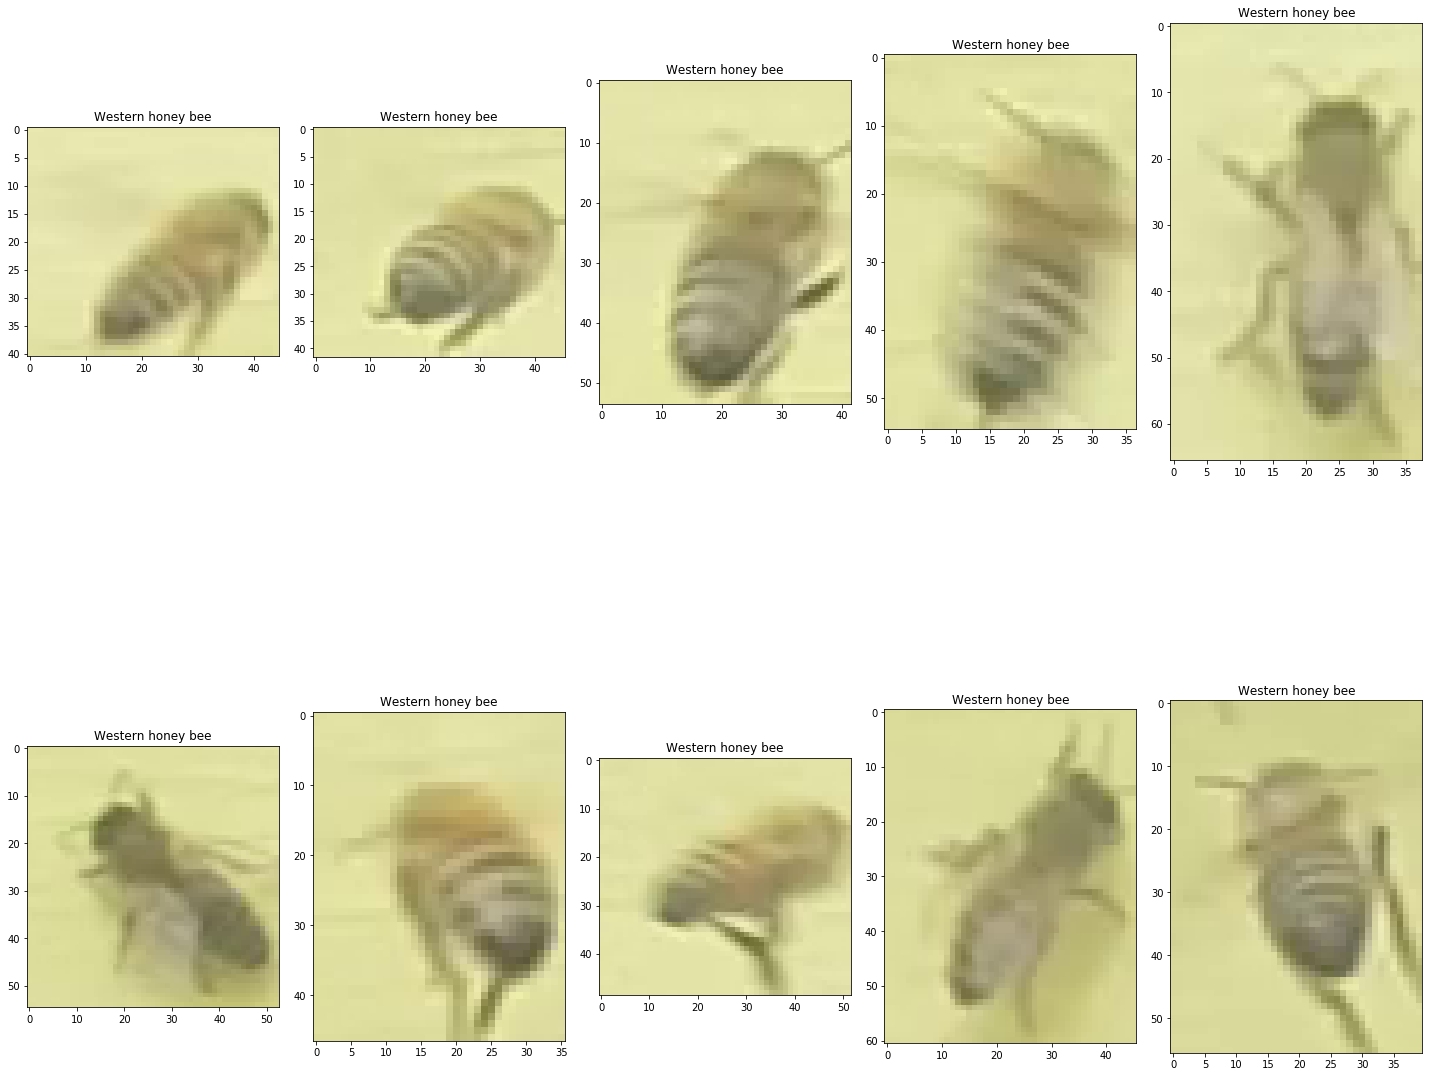

In [16]:
# take a look at the subspecies images in color
for x in subspecies:
    color_img = data['color_paths'][data['subspecies']==x][:10].reset_index(drop=True)
    f, ax = plt.subplots(2, 5, figsize=(20, 20))
    for i in range(len(color_img)):
        row = int(np.floor(i/5))
        col = i%5
        ax[row, col].imshow(imread(color_img[i]))
        ax[row, col].set_title(x)
    plt.tight_layout()
    plt.show()

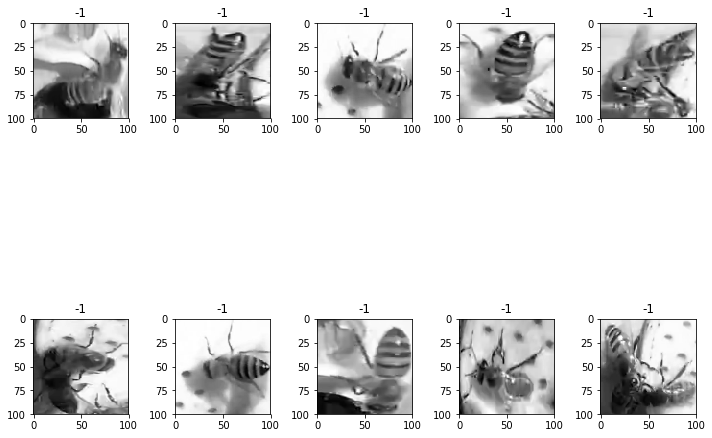

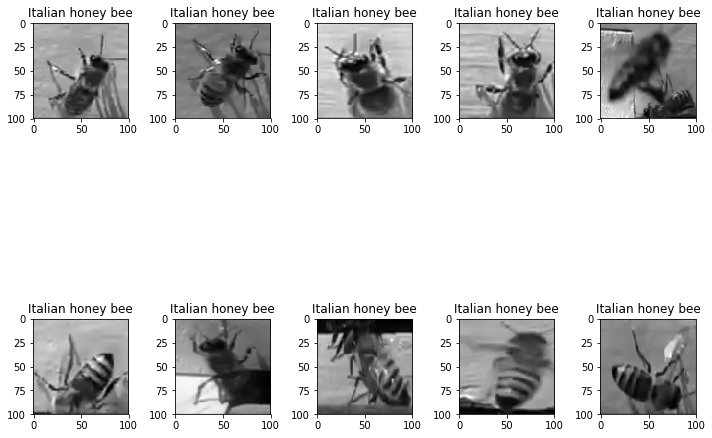

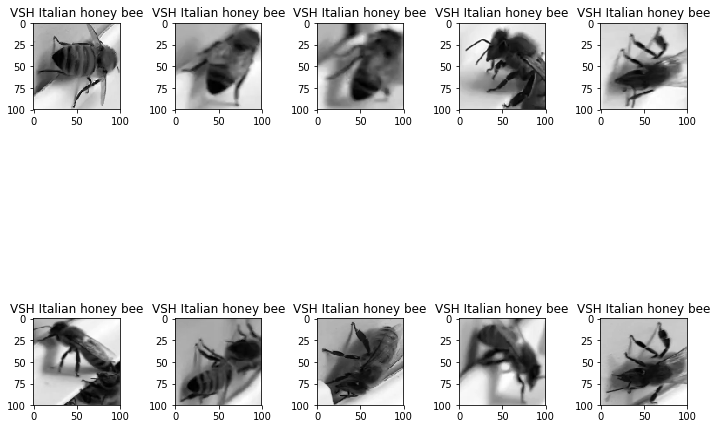

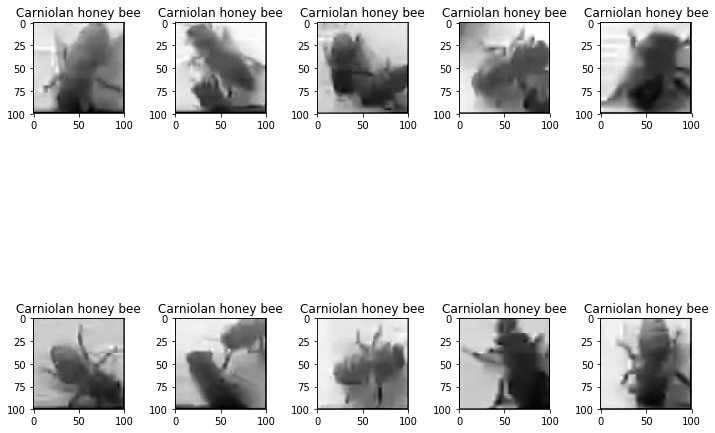

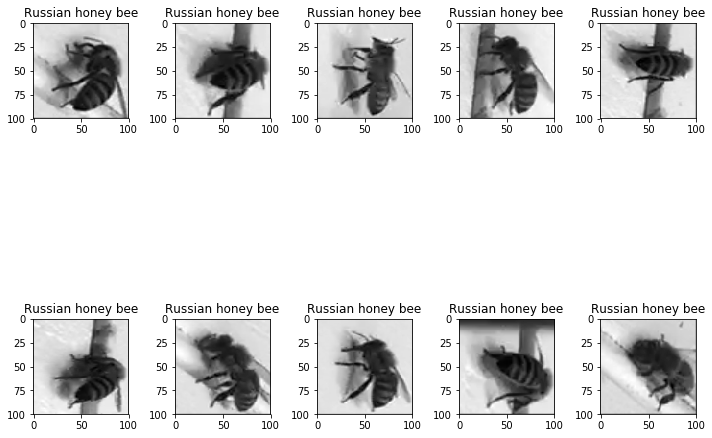

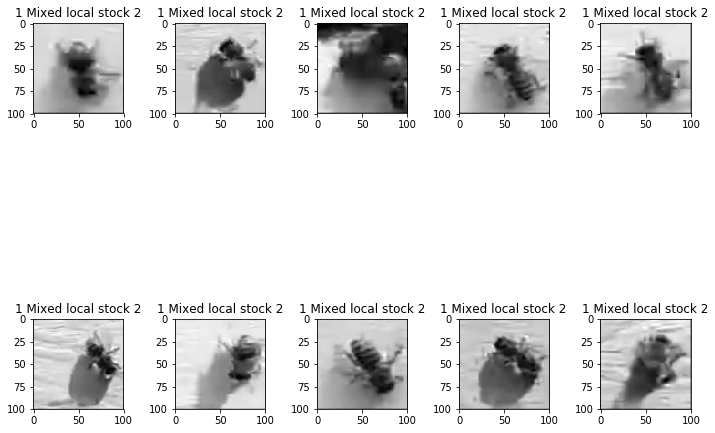

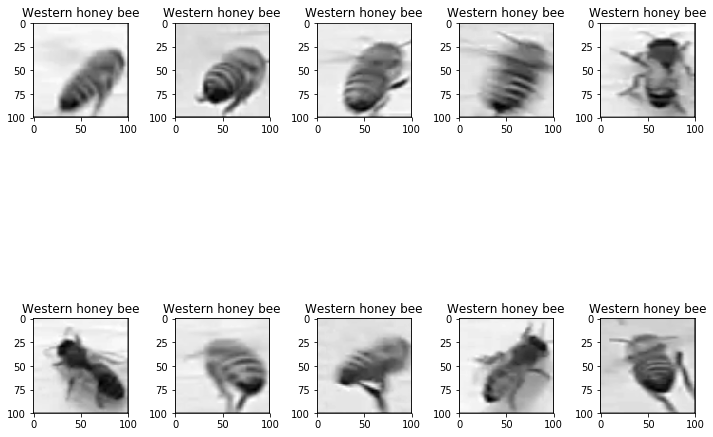

In [20]:
# take a look at the subspecies images in grayscale
for x in subspecies:
    gray_img = data['gray_images'][data['subspecies']==x][:10].reset_index(drop=True)
    f, ax = plt.subplots(2, 5, figsize=(10, 10))
    for i in range(len(gray_img)):
        row = int(np.floor(i/5))
        col = i%5
        ax[row, col].imshow(gray_img[i], cmap='gray')
        ax[row, col].set_title(x)
    plt.tight_layout()
    plt.show()

In [10]:
X = twoD_arr
Y = data.subspecies

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)

# Models we will use
logistic = LogisticRegression(solver='lbfgs', max_iter=10000,
                                           multi_class='multinomial')
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

# #############################################################################
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 50
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 1000
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)

# #############################################################################
# Evaluation



[BernoulliRBM] Iteration 1, pseudo-likelihood = -6640.01, time = 109.82s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -6642.17, time = 104.84s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -6639.55, time = 105.14s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -6644.12, time = 110.15s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -6642.62, time = 110.33s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -6643.42, time = 110.38s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -6639.84, time = 109.66s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -6639.88, time = 109.88s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -6642.71, time = 110.07s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -6641.46, time = 110.14s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -6641.04, time = 102.57s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -6639.70, time = 84.90s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -6640.48, time = 84.88s
[BernoulliRBM] Iteration 14, pseudo-likelihood = 

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [11]:
Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    sklearn.metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    sklearn.metrics.classification_report(Y_test, Y_pred)))

Logistic regression using RBM features:
                       precision    recall  f1-score   support

                   -1       0.00      0.00      0.00        86
1 Mixed local stock 2       0.00      0.00      0.00       113
  Carniolan honey bee       0.00      0.00      0.00       107
    Italian honey bee       0.57      1.00      0.73       594
    Russian honey bee       0.00      0.00      0.00        92
VSH Italian honey bee       0.00      0.00      0.00        38
    Western honey bee       0.00      0.00      0.00         5

            micro avg       0.57      0.57      0.57      1035
            macro avg       0.08      0.14      0.10      1035
         weighted avg       0.33      0.57      0.42      1035


Logistic regression using raw pixel features:
                       precision    recall  f1-score   support

                   -1       0.35      0.38      0.36        86
1 Mixed local stock 2       0.39      0.42      0.41       113
  Carniolan honey bee      

In [ ]:
# try some parameter tuning
params = {'rbm__learning_rate': np.linspace(1e-3, .01, 10),
          'rbm__batch_size':[10,20, 50, 100],
          'rbm__n_iter':[10,20],
          'logistic__C': [1.0, 10.0, 100.0]}
rbm = BernoulliRBM()
logistic = LogisticRegression()
classifier = Pipeline([("rbm", rbm), ("logistic", logistic)])
 
# perform a grid search on the learning rate, number of
# iterations, and number of components on the RBM and
# C for Logistic Regression

print("SEARCHING RBM + LOGISTIC REGRESSION")

# perform a grid search over the parameter
start = time.time()
gs = GridSearchCV(classifier, params, n_jobs = -1, verbose = 1)
gs.fit(X, Y)
gs.best_params_
end = time.time()
print('Search complete in: {:.5f}s'.format(end-start))

SEARCHING RBM + LOGISTIC REGRESSION
Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 144.4min
